In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Wed Jun  7 07:25:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
time: 106 ms (started: 2023-06-07 07:25:29 +00:00)


## **Tahap Awal**

In [ ]:
%cd /content/drive/MyDrive/new_data1

[Errno 2] No such file or directory: '/content/drive/MyDrive/new_data1'
/content
time: 1.82 ms (started: 2023-06-07 07:25:30 +00:00)


In [ ]:
!ls

drive  sample_data
time: 104 ms (started: 2023-06-07 07:25:31 +00:00)


In [ ]:
!unzip face-detector.zip

Archive:  face-detector.zip
replace deploy.prototxt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## **Import Libraries**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import argparse
import os
import itertools
 
# Mengihitung waktu lamanya eksekusi tiap sel di Google Colab
!pip install ipython-autotime
 
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.32 s (started: 2023-06-07 07:25:33 +00:00)


In [ ]:
print(tf.__version__)

2.12.0
time: 596 µs (started: 2023-06-07 07:25:36 +00:00)


## **Preprocessing**

In [ ]:
# Inisialisasi nilai Initial Learning Rate, berapa banyak Epoch pelatihan, dan Batch Size
INIT_LR = 1e-4
EPOCHS = 25
BS = 32
 
# Mengambil gambar dari dataset directory, kemudian inisialisasi data dan class gambar
print("Menginput gambar...")
imagePaths = list(paths.list_images('dataset'))
data = []
labels = []
count = 1
 
# Melakukan perulangan pada image paths
for imagePath in imagePaths:

    print(count)
    count = count + 1
    # Mengekstrak class label dari filename
    label = imagePath.split(os.path.sep)[-2]
    # Memuat input gambar (224x224) dan melakukan proses
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
 
    # Mengupdate data dan labels lists, berurutan
    data.append(image)
    labels.append(label)
 
# Mengkonversi data dan label ke dalam NumPy Arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)
 
# Melakukan one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
print("Input gambar berhasil")

## **Split train dan test data**

In [ ]:
# Mempartisi data ke dalam pelatihan dan pengujian ( 75% : 25% )
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

time: 512 ms (started: 2023-05-24 18:08:09 +00:00)


## **Membuat Object ImageDataGenerator untuk augmentasi**

In [ ]:
# Membentuk training image generator untuk data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

time: 555 µs (started: 2023-05-24 18:08:10 +00:00)


## **MobileNetV2**

In [ ]:
# Arsitektur jaringan Xception
baseModel_MobileNetV2 = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

9406464/9406464 [==============================] - 1s 0us/step
time: 2.97 s (started: 2023-05-24 18:53:26 +00:00)


In [ ]:
baseModel_VGG16Net.trainable = False
baseModel_VGG16Net.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model_MobileNetV2 = keras.Sequential([
    baseModel_MobileNetV2,
    AveragePooling2D(pool_size=(7, 7)),
    Flatten(name="flatten"),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(2, activation="softmax") 
])

time: 608 ms (started: 2023-05-24 18:53:29 +00:00)


In [ ]:
for layer in baseModel_MobileNetV2.layers:
    layer.trainable = False

time: 6.22 ms (started: 2023-05-24 18:53:30 +00:00)


In [ ]:
print("Mengkompilasi model...")

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model_MobileNetV2.compile(loss="binary_crossentropy", optimizer=optimizer,
    metrics=["accuracy"])

model_MobileNetV2.summary()

Mengkompilasi model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 average_pooling2d_2 (Averag  (None, 1, 1, 1280)       0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 128)               163968    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (N

In [ ]:
# Pelatihan model
print("Training model...")
H_MobileNetV2 = model_MobileNetV2.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Training model...
Epoch 1/25
74/74 [==============================] - 48s 603ms/step - loss: 0.6286 - accuracy: 0.8376 - val_loss: 0.2300 - val_accuracy: 0.8950
Epoch 2/25
74/74 [==============================] - 27s 365ms/step - loss: 0.2903 - accuracy: 0.8803 - val_loss: 0.2021 - val_accuracy: 0.9133
Epoch 3/25
74/74 [==============================] - 30s 409ms/step - loss: 0.2650 - accuracy: 0.8951 - val_loss: 0.1616 - val_accuracy: 0.9333
Epoch 4/25
74/74 [==============================] - 27s 366ms/step - loss: 0.2861 - accuracy: 0.8739 - val_loss: 0.1845 - val_accuracy: 0.9317
Epoch 5/25
74/74 [==============================] - 27s 364ms/step - loss: 0.2469 - accuracy: 0.8985 - val_loss: 0.2052 - val_accuracy: 0.9083
Epoch 6/25
74/74 [==============================] - 27s 365ms/step - loss: 0.2335 - accuracy: 0.8951 - val_loss: 0.2219 - val_accuracy: 0.9100
Epoch 7/25
74/74 [==============================] - 27s 369ms/step - loss: 0.2629 - accuracy: 0.8981 - val_loss: 0.1638 - va

### Grafik akuarasi dan error

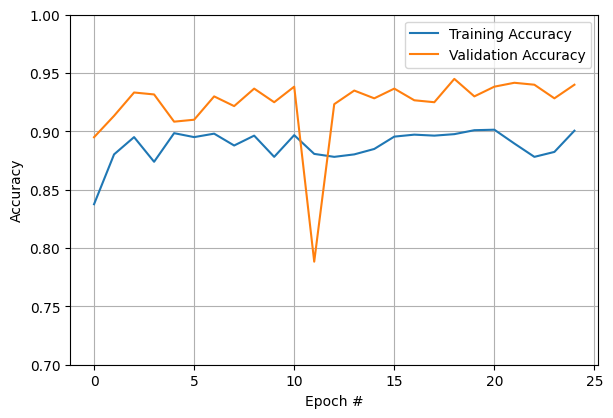

time: 228 ms (started: 2023-05-24 19:06:57 +00:00)


In [ ]:
# Grafik Akurasi
N = EPOCHS
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)
 
plt.subplot(2, 2, 1)
plt.plot(np.arange(0, N), H_MobileNetV2.history["accuracy"],label = "Training Accuracy")
plt.plot(np.arange(0, N), H_MobileNetV2.history["val_accuracy"],label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.ylim([0.7, 1.0])
# plt.title("Kurva Tingkat Akurasi", size=15)
plt.grid(zorder = 0)

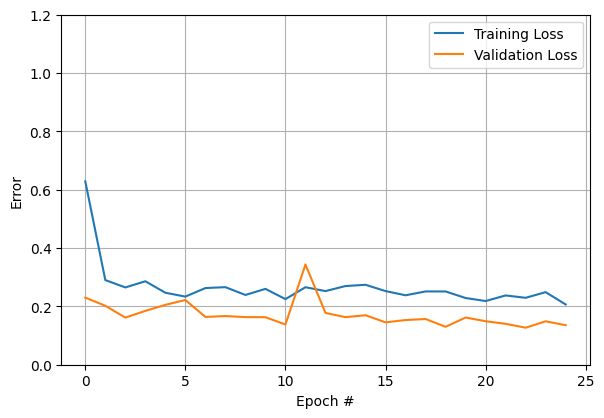

time: 186 ms (started: 2023-05-24 19:06:57 +00:00)


In [ ]:
# Grafik error
N = EPOCHS
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)
 
plt.subplot(2, 2, 2)
plt.plot(np.arange(0, N), H_MobileNetV2.history["loss"],label = "Training Loss")
plt.plot(np.arange(0, N), H_MobileNetV2.history["val_loss"],label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Error")
plt.ylim([0.0, 1.2])
# plt.title("Kurva Tingkat Error", size=15)
plt.grid(zorder = 0)
plt.show()

### Evaluasi Jaringan

In [ ]:
# Memeriksa matriks model
print(model_MobileNetV2.metrics_names)
# Evaluasi data test
print(model_MobileNetV2.evaluate(x= testX, y = testY))

['loss', 'accuracy']
19/19 [==============================] - 1s 70ms/step - loss: 0.1355 - accuracy: 0.9400
[0.13549183309078217, 0.9399999976158142]
time: 2.95 s (started: 2023-05-24 19:06:57 +00:00)


In [ ]:
# Menampilkan matriks yang benar dan matriks hasil prediksi
# Label yang benar
yTrue = np.argmax(testY, axis=1)

# Label prediksi
YPred = model_MobileNetV2.predict(testX, batch_size=BS)
yPred = np.argmax(YPred, axis=1)

print(yTrue)
print(yPred)

19/19 [==============================] - 2s 42ms/step
[0 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0
 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0
 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 1 1
 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 1 0 0 1 1 1 1 0 0 0 0
 0 1 1 0 1 0 1 0 0 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 1 0 1 0 1
 1 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 1
 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1
 1 0 0 1 1 1 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 0 0 1 0 0
 1 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1 0 0
 1 0 0 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 0 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0 0 0
 1 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 1 0 1 0
 0 1 1 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 1 0 1 1 1 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0

### Confusion Matrix

In [ ]:
def get_confusion_matrix(yTrue, yPred):
    n_classes = len(np.unique(yTrue)) 
    conf = np.zeros((n_classes, n_classes))
    for actual, pred in zip(yTrue, yPred):
        conf[int(actual)][int(pred)] += 1
    return conf.astype('int')

time: 612 µs (started: 2023-05-24 19:07:02 +00:00)


In [ ]:
conf = get_confusion_matrix(yTrue, yPred)
conf

array([[295,   5],
       [ 31, 269]])

time: 4.28 ms (started: 2023-05-24 19:07:02 +00:00)


Text(0.5, 23.52222222222222, 'Prediction Label')

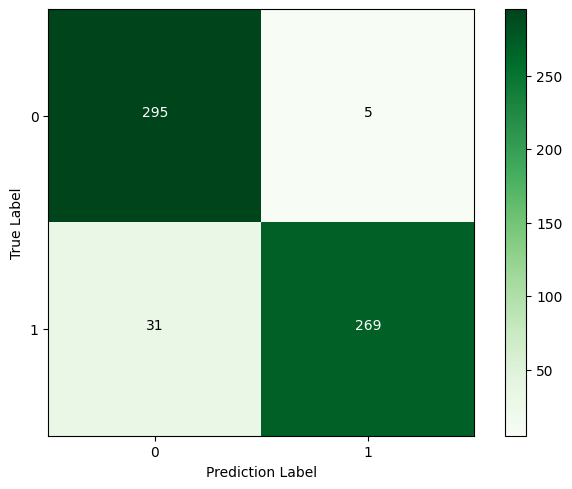

time: 241 ms (started: 2023-05-24 19:07:02 +00:00)


In [ ]:
classes = [0, 1]
# Plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
# plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Prediction Label')

### Analisis mAP

In [ ]:
# Membuat prediksi dari pengujian
predIdxs = model_MobileNetV2.predict(testX, batch_size=BS)
 
# Untuk setiap gambar dalam set pengujian, kita perlu menemukan indeks label
# dengan probabilitas prediksi terbesar
predIdxs = np.argmax(predIdxs, axis=1)
 
# Menampilkan laporan klasifikasi yang diformat dengan baik
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_, digits=6))

19/19 [==============================] - 1s 39ms/step
              precision    recall  f1-score   support

   with_mask   0.904908  0.983333  0.942492       300
without_mask   0.981752  0.896667  0.937282       300

    accuracy                       0.940000       600
   macro avg   0.943330  0.940000  0.939887       600
weighted avg   0.943330  0.940000  0.939887       600

time: 1.63 s (started: 2023-05-24 19:07:03 +00:00)


### Menyimpan Model

In [ ]:
model_MobileNetV2.save('model_MobileNetV2.h5')

time: 398 ms (started: 2023-05-24 19:11:54 +00:00)


## **VGG16Net**

In [ ]:
# Arsitektur jaringan VGG16Net
baseModel_VGG16Net = tf.keras.applications.VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

58889256/58889256 [==============================] - 4s 0us/step
time: 7.34 s (started: 2023-05-24 18:08:10 +00:00)


In [ ]:
baseModel_VGG16Net.trainable = False
baseModel_VGG16Net.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model_VGG16Net = keras.Sequential([
    baseModel_VGG16Net,
    AveragePooling2D(pool_size=(7, 7)),
    Flatten(name="flatten"),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(2, activation="softmax") 
])

time: 204 ms (started: 2023-05-24 18:08:17 +00:00)


In [ ]:
for layer in baseModel_VGG16Net.layers:
    layer.trainable = False

time: 1.3 ms (started: 2023-05-24 18:08:17 +00:00)


In [ ]:
print("Mengkompilasi model...")

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model_VGG16Net.compile(loss="binary_crossentropy", optimizer=optimizer,
    metrics=["accuracy"])

model_VGG16Net.summary()

Mengkompilasi model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 average_pooling2d (AverageP  (None, 1, 1, 512)        0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                 

In [ ]:
# Pelatihan model
print("Training model...")
H_VGG16Net = model_VGG16Net.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Training model...
Epoch 1/25
74/74 [==============================] - 65s 668ms/step - loss: 0.2565 - accuracy: 0.9628 - val_loss: 0.2269 - val_accuracy: 0.9717
Epoch 2/25
74/74 [==============================] - 33s 443ms/step - loss: 0.0633 - accuracy: 0.9805 - val_loss: 0.0984 - val_accuracy: 0.9750
Epoch 3/25
74/74 [==============================] - 31s 419ms/step - loss: 0.0545 - accuracy: 0.9831 - val_loss: 0.0563 - val_accuracy: 0.9750
Epoch 4/25
74/74 [==============================] - 34s 453ms/step - loss: 0.0446 - accuracy: 0.9877 - val_loss: 0.1120 - val_accuracy: 0.9667
Epoch 5/25
74/74 [==============================] - 31s 412ms/step - loss: 0.0395 - accuracy: 0.9882 - val_loss: 0.0497 - val_accuracy: 0.9900
Epoch 6/25
74/74 [==============================] - 31s 414ms/step - loss: 0.0684 - accuracy: 0.9805 - val_loss: 0.0397 - val_accuracy: 0.9883
Epoch 7/25
74/74 [==============================] - 35s 469ms/step - loss: 0.0375 - accuracy: 0.9898 - val_loss: 0.0487 - va

### Grafik akuarasi dan error

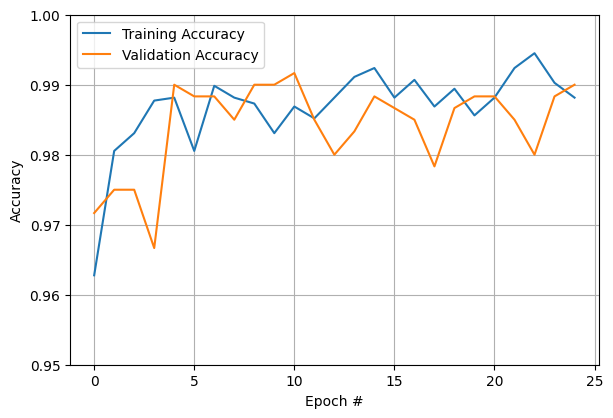

time: 387 ms (started: 2023-05-24 18:24:17 +00:00)


In [ ]:
# Grafik Akurasi
N = EPOCHS
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)
 
plt.subplot(2, 2, 1)
plt.plot(np.arange(0, N), H_VGG16Net.history["accuracy"],label = "Training Accuracy")
plt.plot(np.arange(0, N), H_VGG16Net.history["val_accuracy"],label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.ylim([0.95, 1.0])
# plt.title("Kurva Tingkat Akurasi", size=15)
plt.grid(zorder = 0)

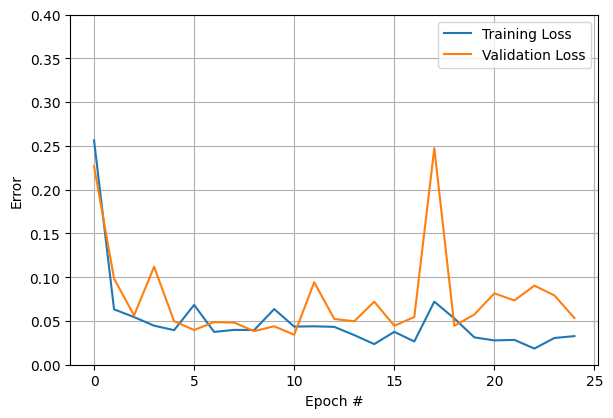

time: 241 ms (started: 2023-05-24 18:24:18 +00:00)


In [ ]:
# Grafik error
N = EPOCHS
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)
 
plt.subplot(2, 2, 2)
plt.plot(np.arange(0, N), H_VGG16Net.history["loss"],label = "Training Loss")
plt.plot(np.arange(0, N), H_VGG16Net.history["val_loss"],label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Error")
plt.ylim([0.0, 0.4])
# plt.title("Kurva Tingkat Error", size=15)
plt.grid(zorder = 0)
plt.show()

### Evaluasi Jaringan

In [ ]:
# Memeriksa matriks model
print(model_VGG16Net.metrics_names)
# Evaluasi data test
print(model_VGG16Net.evaluate(x= testX, y = testY))

['loss', 'accuracy']
19/19 [==============================] - 6s 320ms/step - loss: 0.0533 - accuracy: 0.9900
[0.053339723497629166, 0.9900000095367432]
time: 10.6 s (started: 2023-05-24 18:24:18 +00:00)


In [ ]:
# Menampilkan matriks yang benar dan matriks hasil prediksi
# Label yang benar
yTrue = np.argmax(testY, axis=1)

# Label prediksi
YPred = model_VGG16Net.predict(testX, batch_size=BS)
yPred = np.argmax(YPred, axis=1)

print(yTrue)
print(yPred)

19/19 [==============================] - 3s 127ms/step
[0 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0
 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0
 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 1 1
 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 1 0 0 1 1 1 1 0 0 0 0
 0 1 1 0 1 0 1 0 0 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 1 0 1 0 1
 1 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 1
 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1
 1 0 0 1 1 1 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 0 0 1 0 0
 1 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1 0 0
 1 0 0 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 0 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0 0 0
 1 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 1 0 1 0
 0 1 1 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 1 0 1 1 1 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 

### Confusion Matrix

In [ ]:
def get_confusion_matrix(yTrue, yPred):
    n_classes = len(np.unique(yTrue)) 
    conf = np.zeros((n_classes, n_classes))
    for actual, pred in zip(yTrue, yPred):
        conf[int(actual)][int(pred)] += 1
    return conf.astype('int')

time: 462 µs (started: 2023-05-24 18:24:32 +00:00)


In [ ]:
conf = get_confusion_matrix(yTrue, yPred)
conf

array([[299,   1],
       [  5, 295]])

time: 4.28 ms (started: 2023-05-24 18:24:32 +00:00)


Text(0.5, 23.52222222222222, 'Prediction Label')

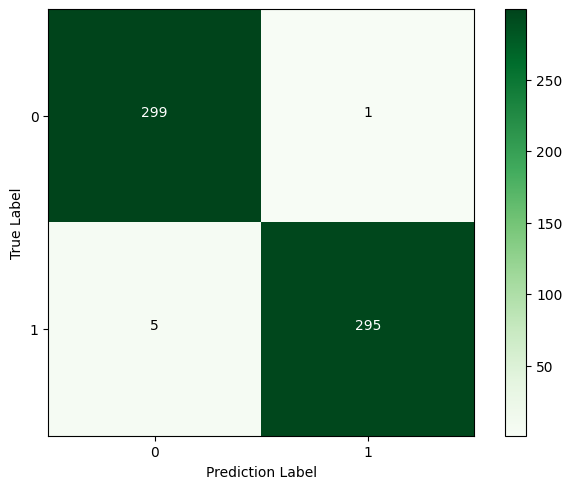

time: 268 ms (started: 2023-05-24 18:24:32 +00:00)


In [ ]:
classes = [0, 1]
# Plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
# plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Prediction Label')

### Analisis mAP

In [ ]:
# Membuat prediksi dari pengujian
predIdxs = model_VGG16Net.predict(testX, batch_size=BS)
 
# Untuk setiap gambar dalam set pengujian, kita perlu menemukan indeks label
# dengan probabilitas prediksi terbesar
predIdxs = np.argmax(predIdxs, axis=1)
 
# Menampilkan laporan klasifikasi yang diformat dengan baik
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_, digits=6))

19/19 [==============================] - 2s 126ms/step
              precision    recall  f1-score   support

   with_mask   0.983553  0.996667  0.990066       300
without_mask   0.996622  0.983333  0.989933       300

    accuracy                       0.990000       600
   macro avg   0.990087  0.990000  0.990000       600
weighted avg   0.990087  0.990000  0.990000       600

time: 2.92 s (started: 2023-05-24 18:24:32 +00:00)


### Menyimpan Model

In [ ]:
model_VGG16Net.save('model_VGG16NET.h5')

time: 2.9 s (started: 2023-05-24 18:24:35 +00:00)


## **EfficientNetB7**

In [ ]:
# Arsitektur jaringan EfficientNetB7
baseModel_EfficientNetB7 = tf.keras.applications.EfficientNetB7(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

258076736/258076736 [==============================] - 14s 0us/step
time: 22.7 s (started: 2023-05-24 18:25:05 +00:00)


In [ ]:
baseModel_EfficientNetB7.trainable = False
baseModel_EfficientNetB7.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['normalization[0][0

In [ ]:
model_EfficientNetB7 = keras.Sequential([
    baseModel_EfficientNetB7,
    AveragePooling2D(pool_size=(7, 7)),
    Flatten(name="flatten"),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(2, activation="softmax") 
])

time: 4.83 s (started: 2023-05-24 18:25:32 +00:00)


In [ ]:
for layer in baseModel_EfficientNetB7.layers:
    layer.trainable = False

time: 25.5 ms (started: 2023-05-24 18:25:36 +00:00)


In [ ]:
print("Mengkompilasi model...")

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model_EfficientNetB7.compile(loss="binary_crossentropy", optimizer=optimizer,
    metrics=["accuracy"])

model_EfficientNetB7.summary()

Mengkompilasi model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 7, 7, 2560)       64097687  
                                                                 
 average_pooling2d_1 (Averag  (None, 1, 1, 2560)       0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 2560)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               327808    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                               

In [ ]:
# Pelatihan model
print("Training model...")
H_EfficientNetB7 = model_EfficientNetB7.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Training model...
Epoch 1/25
74/74 [==============================] - 99s 707ms/step - loss: 0.3009 - accuracy: 0.8828 - val_loss: 0.2544 - val_accuracy: 0.9000
Epoch 2/25
74/74 [==============================] - 47s 638ms/step - loss: 0.2622 - accuracy: 0.8849 - val_loss: 0.1481 - val_accuracy: 0.9350
Epoch 3/25
74/74 [==============================] - 51s 687ms/step - loss: 0.2220 - accuracy: 0.9086 - val_loss: 0.1560 - val_accuracy: 0.9283
Epoch 4/25
74/74 [==============================] - 46s 625ms/step - loss: 0.2189 - accuracy: 0.9082 - val_loss: 0.1519 - val_accuracy: 0.9383
Epoch 5/25
74/74 [==============================] - 46s 622ms/step - loss: 0.2160 - accuracy: 0.9048 - val_loss: 0.1716 - val_accuracy: 0.9333
Epoch 6/25
74/74 [==============================] - 45s 606ms/step - loss: 0.1969 - accuracy: 0.9141 - val_loss: 0.1358 - val_accuracy: 0.9450
Epoch 7/25
74/74 [==============================] - 40s 542ms/step - loss: 0.1888 - accuracy: 0.9150 - val_loss: 0.1701 - va

### Grafik akuarasi dan error

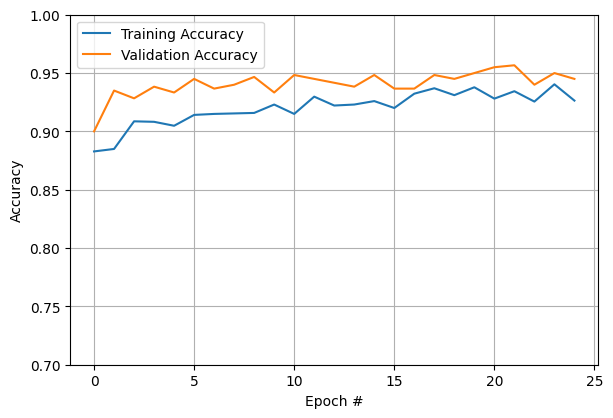

time: 218 ms (started: 2023-05-24 18:50:31 +00:00)


In [ ]:
# Grafik Akurasi
N = EPOCHS
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)
 
plt.subplot(2, 2, 1)
plt.plot(np.arange(0, N), H_EfficientNetB7.history["accuracy"],label = "Training Accuracy")
plt.plot(np.arange(0, N), H_EfficientNetB7.history["val_accuracy"],label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.ylim([0.7, 1.0])
# plt.title("Kurva Tingkat Akurasi", size=15)
plt.grid(zorder = 0)

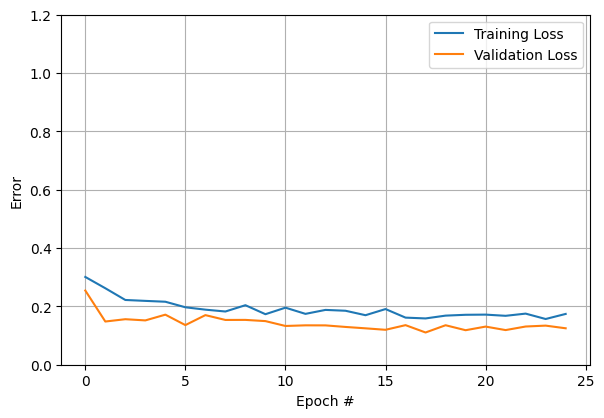

time: 188 ms (started: 2023-05-24 18:50:31 +00:00)


In [ ]:
# Grafik error
N = EPOCHS
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)
 
plt.subplot(2, 2, 2)
plt.plot(np.arange(0, N), H_EfficientNetB7.history["loss"],label = "Training Loss")
plt.plot(np.arange(0, N), H_EfficientNetB7.history["val_loss"],label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Error")
plt.ylim([0.0, 1.2])
# plt.title("Kurva Tingkat Error", size=15)
plt.grid(zorder = 0)
plt.show()

### Evaluasi Jaringan

In [ ]:
# Memeriksa matriks model
print(model_EfficientNetB7.metrics_names)
# Evaluasi data test
print(model_EfficientNetB7.evaluate(x= testX, y = testY))

['loss', 'accuracy']
19/19 [==============================] - 9s 414ms/step - loss: 0.1249 - accuracy: 0.9450
[0.12493381649255753, 0.9449999928474426]
time: 10.6 s (started: 2023-05-24 18:50:31 +00:00)


In [ ]:
# Menampilkan matriks yang benar dan matriks hasil prediksi
# Label yang benar
yTrue = np.argmax(testY, axis=1)

# Label prediksi
YPred = model_EfficientNetB7.predict(testX, batch_size=BS)
yPred = np.argmax(YPred, axis=1)

print(yTrue)
print(yPred)

19/19 [==============================] - 13s 339ms/step
[0 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0
 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0
 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 1 1
 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 1 0 0 1 1 1 1 0 0 0 0
 0 1 1 0 1 0 1 0 0 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 1 0 1 0 1
 1 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 1
 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1
 1 0 0 1 1 1 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 0 0 1 0 0
 1 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1 0 0
 1 0 0 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 0 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0 0 0
 1 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 1 0 1 0
 0 1 1 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 1 0 1 1 1 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0

### Confusion Matrix

In [ ]:
def get_confusion_matrix(yTrue, yPred):
    n_classes = len(np.unique(yTrue)) 
    conf = np.zeros((n_classes, n_classes))
    for actual, pred in zip(yTrue, yPred):
        conf[int(actual)][int(pred)] += 1
    return conf.astype('int')

time: 736 µs (started: 2023-05-24 18:50:59 +00:00)


In [ ]:
conf = get_confusion_matrix(yTrue, yPred)
conf

array([[280,  20],
       [ 13, 287]])

time: 5.43 ms (started: 2023-05-24 18:50:59 +00:00)


Text(0.5, 23.52222222222222, 'Prediction Label')

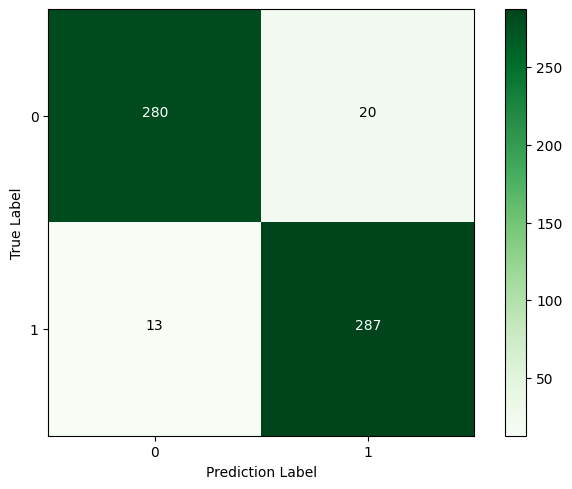

time: 234 ms (started: 2023-05-24 18:50:59 +00:00)


In [ ]:
classes = [0, 1]
# Plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
# plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Prediction Label')

### Analisis mAP

In [ ]:
# Membuat prediksi dari pengujian
predIdxs = model_EfficientNetB7.predict(testX, batch_size=BS)
 
# Untuk setiap gambar dalam set pengujian, kita perlu menemukan indeks label
# dengan probabilitas prediksi terbesar
predIdxs = np.argmax(predIdxs, axis=1)
 
# Menampilkan laporan klasifikasi yang diformat dengan baik
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_, digits=6))

19/19 [==============================] - 6s 342ms/step
              precision    recall  f1-score   support

   with_mask   0.955631  0.933333  0.944351       300
without_mask   0.934853  0.956667  0.945634       300

    accuracy                       0.945000       600
   macro avg   0.945242  0.945000  0.944993       600
weighted avg   0.945242  0.945000  0.944993       600

time: 6.92 s (started: 2023-05-24 18:50:59 +00:00)


### Menyimpan Model

In [ ]:
model_EfficientNetB7.save('model_EfficientNetB7.h5')

TypeError: ignored

time: 869 ms (started: 2023-05-24 18:51:51 +00:00)


## **Xception**

In [ ]:
# Arsitektur jaringan Xception
baseModel_Xception = tf.keras.applications.Xception(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

83683744/83683744 [==============================] - 6s 0us/step
time: 7.17 s (started: 2023-05-24 19:21:47 +00:00)


In [ ]:
baseModel_Xception.trainable = False
baseModel_Xception.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [ ]:
model_Xception = keras.Sequential([
    baseModel_Xception,
    AveragePooling2D(pool_size=(7, 7)),
    Flatten(name="flatten"),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(2, activation="softmax") 
])

time: 939 ms (started: 2023-05-24 19:21:55 +00:00)


In [ ]:
for layer in baseModel_Xception.layers:
    layer.trainable = False

time: 7.15 ms (started: 2023-05-24 19:21:56 +00:00)


In [ ]:
print("Mengkompilasi model...")

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model_Xception.compile(loss="binary_crossentropy", optimizer=optimizer,
    metrics=["accuracy"])

model_Xception.summary()

Mengkompilasi model...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 average_pooling2d_3 (Averag  (None, 1, 1, 2048)       0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               262272    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 2)                 258       
                               

In [ ]:
# Pelatihan model
print("Training model...")
H_Xception = model_Xception.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Training model...
Epoch 1/25
74/74 [==============================] - 62s 777ms/step - loss: 1.6158 - accuracy: 0.7445 - val_loss: 0.2800 - val_accuracy: 0.8917
Epoch 2/25
74/74 [==============================] - 39s 521ms/step - loss: 0.4063 - accuracy: 0.8101 - val_loss: 0.2484 - val_accuracy: 0.8900
Epoch 3/25
74/74 [==============================] - 30s 404ms/step - loss: 0.3850 - accuracy: 0.8228 - val_loss: 0.2604 - val_accuracy: 0.9017
Epoch 4/25
74/74 [==============================] - 30s 406ms/step - loss: 0.3877 - accuracy: 0.8261 - val_loss: 0.2332 - val_accuracy: 0.9000
Epoch 5/25
74/74 [==============================] - 31s 417ms/step - loss: 0.3942 - accuracy: 0.8287 - val_loss: 0.2479 - val_accuracy: 0.8933
Epoch 6/25
74/74 [==============================] - 31s 417ms/step - loss: 0.3624 - accuracy: 0.8524 - val_loss: 0.2358 - val_accuracy: 0.9133
Epoch 7/25
74/74 [==============================] - 31s 419ms/step - loss: 0.3847 - accuracy: 0.8202 - val_loss: 0.2288 - va

### Grafik akuarasi dan error

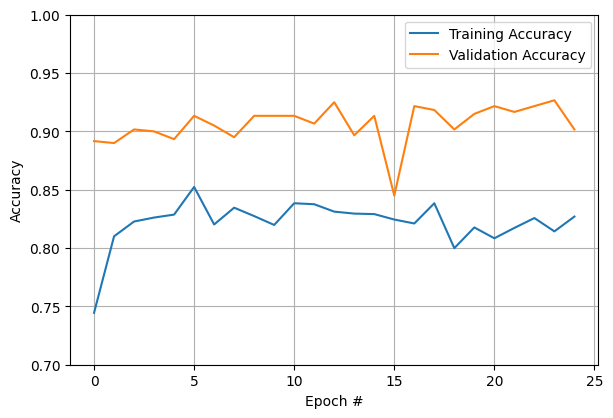

time: 805 ms (started: 2023-05-24 19:37:58 +00:00)


In [ ]:
# Grafik Akurasi
N = EPOCHS
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)
 
plt.subplot(2, 2, 1)
plt.plot(np.arange(0, N), H_Xception.history["accuracy"],label = "Training Accuracy")
plt.plot(np.arange(0, N), H_Xception.history["val_accuracy"],label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.ylim([0.7, 1.0])
# plt.title("Kurva Tingkat Akurasi", size=15)
plt.grid(zorder = 0)

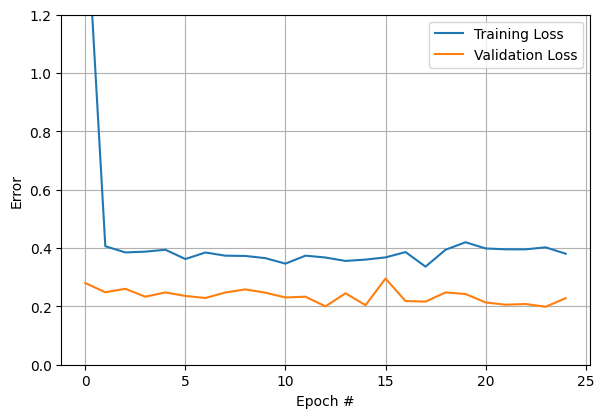

time: 186 ms (started: 2023-05-24 19:37:59 +00:00)


In [ ]:
# Grafik error
N = EPOCHS
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)
 
plt.subplot(2, 2, 2)
plt.plot(np.arange(0, N), H_Xception.history["loss"],label = "Training Loss")
plt.plot(np.arange(0, N), H_Xception.history["val_loss"],label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Error")
plt.ylim([0.0, 1.2])
# plt.title("Kurva Tingkat Error", size=15)
plt.grid(zorder = 0)
plt.show()

### Evaluasi Jaringan

In [ ]:
# Memeriksa matriks model
print(model_Xception.metrics_names)
# Evaluasi data test
print(model_Xception.evaluate(x= testX, y = testY))

['loss', 'accuracy']
19/19 [==============================] - 4s 209ms/step - loss: 0.2281 - accuracy: 0.9017
[0.22809666395187378, 0.9016666412353516]
time: 4.31 s (started: 2023-05-24 19:37:59 +00:00)


In [ ]:
# Menampilkan matriks yang benar dan matriks hasil prediksi
# Label yang benar
yTrue = np.argmax(testY, axis=1)

# Label prediksi
YPred = model_Xception.predict(testX, batch_size=BS)
yPred = np.argmax(YPred, axis=1)

print(yTrue)
print(yPred)

19/19 [==============================] - 3s 129ms/step
[0 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0
 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0
 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 1 1
 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 1 0 0 1 1 1 1 0 0 0 0
 0 1 1 0 1 0 1 0 0 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 1 0 1 0 1
 1 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 1
 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1
 1 0 0 1 1 1 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 0 0 1 0 0
 1 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1 0 0
 1 0 0 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 0 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0 0 0
 1 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 1 0 1 0
 0 1 1 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 1 0 1 1 1 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 

### Confusion Matrix

In [ ]:
def get_confusion_matrix(yTrue, yPred):
    n_classes = len(np.unique(yTrue)) 
    conf = np.zeros((n_classes, n_classes))
    for actual, pred in zip(yTrue, yPred):
        conf[int(actual)][int(pred)] += 1
    return conf.astype('int')

time: 760 µs (started: 2023-05-24 19:38:07 +00:00)


In [ ]:
conf = get_confusion_matrix(yTrue, yPred)
conf

array([[247,  53],
       [  6, 294]])

time: 3.93 ms (started: 2023-05-24 19:38:07 +00:00)


Text(0.5, 23.52222222222222, 'Prediction Label')

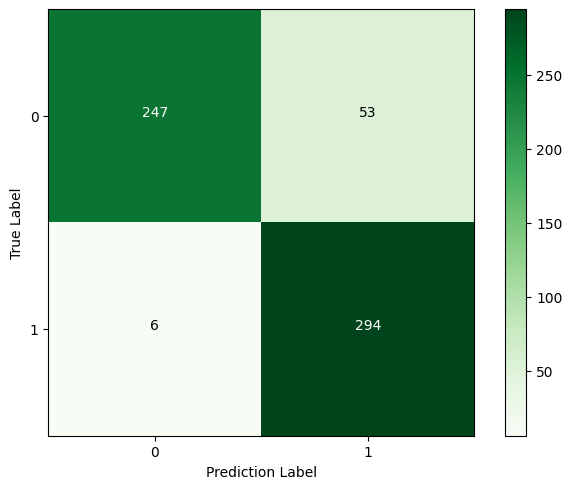

time: 254 ms (started: 2023-05-24 19:38:07 +00:00)


In [ ]:
classes = [0, 1]
# Plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
# plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Prediction Label')

### Analisis mAP

In [ ]:
# Membuat prediksi dari pengujian
predIdxs = model_Xception.predict(testX, batch_size=BS)
 
# Untuk setiap gambar dalam set pengujian, kita perlu menemukan indeks label
# dengan probabilitas prediksi terbesar
predIdxs = np.argmax(predIdxs, axis=1)
 
# Menampilkan laporan klasifikasi yang diformat dengan baik
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_, digits=6))

19/19 [==============================] - 2s 131ms/step
              precision    recall  f1-score   support

   with_mask   0.976285  0.823333  0.893309       300
without_mask   0.847262  0.980000  0.908810       300

    accuracy                       0.901667       600
   macro avg   0.911773  0.901667  0.901060       600
weighted avg   0.911773  0.901667  0.901060       600

time: 3.46 s (started: 2023-05-24 19:39:13 +00:00)


### Menyimpan Model

In [ ]:
model_Xception.save('model_Xception.h5')

time: 672 ms (started: 2023-05-24 19:38:10 +00:00)


## **InceptionResNetV2**

In [ ]:
# Arsitektur jaringan Xception
baseModel_InceptionResNetV2 = tf.keras.applications.InceptionResNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

219055592/219055592 [==============================] - 11s 0us/step
time: 17.2 s (started: 2023-05-24 19:39:31 +00:00)


In [ ]:
baseModel_InceptionResNetV2.trainable = False
baseModel_InceptionResNetV2.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 111, 111, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 111, 111, 32  96         ['conv2d_4[0][0]']               
 rmalization)                   )                                               

In [ ]:
model_InceptionResNetV2 = keras.Sequential([
    baseModel_InceptionResNetV2,
    # AveragePooling2D(pool_size=(7, 7)),
    Flatten(name="flatten"),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(2, activation="softmax") 
])

time: 2.63 s (started: 2023-05-24 19:39:51 +00:00)


In [ ]:
for layer in baseModel_InceptionResNetV2.layers:
    layer.trainable = False

time: 22.8 ms (started: 2023-05-24 19:39:54 +00:00)


In [ ]:
print("Mengkompilasi model...")

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model_InceptionResNetV2.compile(loss="binary_crossentropy", optimizer=optimizer,
    metrics=["accuracy"])

model_InceptionResNetV2.summary()

Mengkompilasi model...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten (Flatten)           (None, 38400)             0         
                                                                 
 dense_8 (Dense)             (None, 128)               4915328   
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 2)                 258       
                                                                 
Total params: 59,252,322
Trainable params: 4,915,586
Non-trainable params: 54,336,736
___________

In [ ]:
# Pelatihan model
print("Training model...")
H_InceptionResNetV2 = model_Xception.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

Training model...
Epoch 1/25
74/74 [==============================] - 33s 443ms/step - loss: 0.3898 - accuracy: 0.8156 - val_loss: 0.2461 - val_accuracy: 0.9167
Epoch 2/25
74/74 [==============================] - 31s 412ms/step - loss: 0.3672 - accuracy: 0.8363 - val_loss: 0.2066 - val_accuracy: 0.9217
Epoch 3/25
74/74 [==============================] - 31s 413ms/step - loss: 0.3429 - accuracy: 0.8541 - val_loss: 0.2250 - val_accuracy: 0.9100
Epoch 4/25
74/74 [==============================] - 30s 404ms/step - loss: 0.3687 - accuracy: 0.8266 - val_loss: 0.2332 - val_accuracy: 0.9167
Epoch 5/25
74/74 [==============================] - 30s 403ms/step - loss: 0.3580 - accuracy: 0.8503 - val_loss: 0.2518 - val_accuracy: 0.9167
Epoch 6/25
74/74 [==============================] - 30s 404ms/step - loss: 0.3511 - accuracy: 0.8384 - val_loss: 0.1931 - val_accuracy: 0.9383
Epoch 7/25
74/74 [==============================] - 30s 405ms/step - loss: 0.3626 - accuracy: 0.8397 - val_loss: 0.2230 - va

### Grafik akuarasi dan error

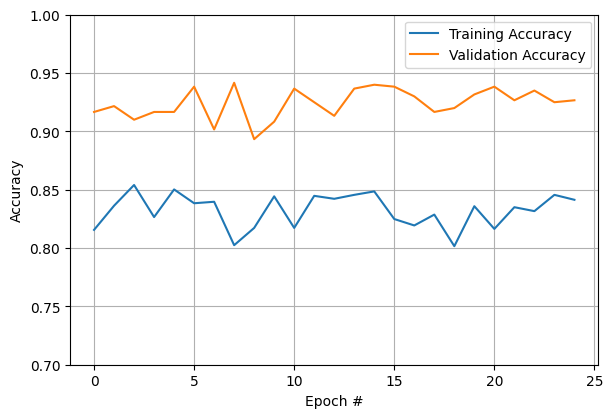

time: 246 ms (started: 2023-05-24 19:54:57 +00:00)


In [ ]:
# Grafik Akurasi
N = EPOCHS
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)
 
plt.subplot(2, 2, 1)
plt.plot(np.arange(0, N), H_InceptionResNetV2.history["accuracy"],label = "Training Accuracy")
plt.plot(np.arange(0, N), H_InceptionResNetV2.history["val_accuracy"],label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.ylim([0.7, 1.0])
# plt.title("Kurva Tingkat Akurasi", size=15)
plt.grid(zorder = 0)

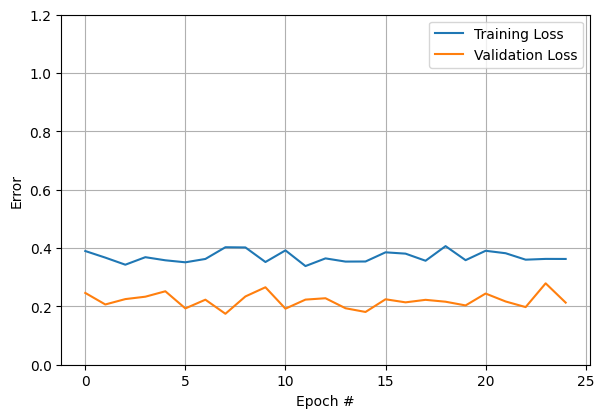

time: 181 ms (started: 2023-05-24 19:54:57 +00:00)


In [ ]:
# Grafik error
N = EPOCHS
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)
 
plt.subplot(2, 2, 2)
plt.plot(np.arange(0, N), H_InceptionResNetV2.history["loss"],label = "Training Loss")
plt.plot(np.arange(0, N), H_InceptionResNetV2.history["val_loss"],label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Error")
plt.ylim([0.0, 1.2])
# plt.title("Kurva Tingkat Error", size=15)
plt.grid(zorder = 0)
plt.show()

### Evaluasi Jaringan

In [ ]:
# Memeriksa matriks model
print(model_InceptionResNetV2.metrics_names)
# Evaluasi data test
print(model_InceptionResNetV2.evaluate(x= testX, y = testY))

[]
19/19 [==============================] - 13s 247ms/step - loss: 30.7039 - accuracy: 0.5317
[30.703895568847656, 0.5316666960716248]
time: 16.8 s (started: 2023-05-24 19:54:57 +00:00)


In [ ]:
# Menampilkan matriks yang benar dan matriks hasil prediksi
# Label yang benar
yTrue = np.argmax(testY, axis=1)

# Label prediksi
YPred = model_InceptionResNetV2.predict(testX, batch_size=BS)
yPred = np.argmax(YPred, axis=1)

print(yTrue)
print(yPred)

19/19 [==============================] - 6s 168ms/step
[0 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0
 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0
 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 1 1
 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 1 0 0 1 1 1 1 0 0 0 0
 0 1 1 0 1 0 1 0 0 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 1 0 1 0 1
 1 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 1
 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1
 1 0 0 1 1 1 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 0 0 1 0 0
 1 0 0 0 1 0 0 1 0 0 0 0 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 1 1 1 0 0 1 1 0 0
 1 0 0 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 0 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0 0 0
 1 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 1 0 1 0
 0 1 1 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0
 1 0 1 1 1 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 

### Confusion Matrix

In [ ]:
def get_confusion_matrix(yTrue, yPred):
    n_classes = len(np.unique(yTrue)) 
    conf = np.zeros((n_classes, n_classes))
    for actual, pred in zip(yTrue, yPred):
        conf[int(actual)][int(pred)] += 1
    return conf.astype('int')

time: 691 µs (started: 2023-05-24 19:55:21 +00:00)


In [ ]:
conf = get_confusion_matrix(yTrue, yPred)
conf

array([[ 26, 274],
       [  7, 293]])

time: 12.6 ms (started: 2023-05-24 19:55:21 +00:00)


Text(0.5, 23.52222222222222, 'Prediction Label')

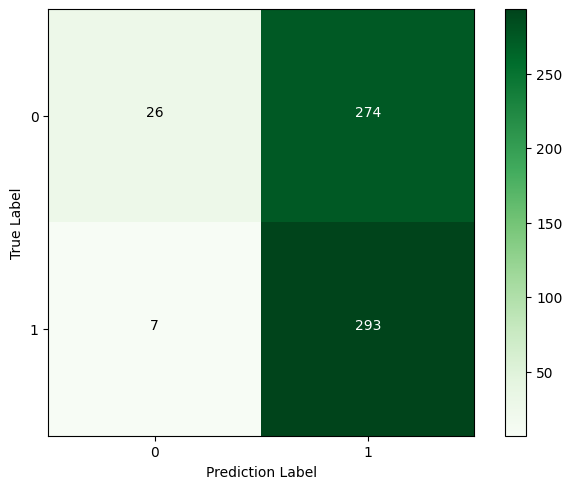

time: 530 ms (started: 2023-05-24 19:55:21 +00:00)


In [ ]:
classes = [0, 1]
# Plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
# plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Prediction Label')

### Analisis mAP

In [ ]:
# Membuat prediksi dari pengujian
predIdxs = model_InceptionResNetV2.predict(testX, batch_size=BS)
 
# Untuk setiap gambar dalam set pengujian, kita perlu menemukan indeks label
# dengan probabilitas prediksi terbesar
predIdxs = np.argmax(predIdxs, axis=1)
 
# Menampilkan laporan klasifikasi yang diformat dengan baik
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_, digits=6))

19/19 [==============================] - 3s 168ms/step
              precision    recall  f1-score   support

   with_mask   0.787879  0.086667  0.156156       300
without_mask   0.516755  0.976667  0.675894       300

    accuracy                       0.531667       600
   macro avg   0.652317  0.531667  0.416025       600
weighted avg   0.652317  0.531667  0.416025       600

time: 4.66 s (started: 2023-05-24 19:56:06 +00:00)


### Menyimpan Model

In [ ]:
model_InceptionResNetV2.save('model_InceptionResNetV2.h5')

time: 5.61 s (started: 2023-05-24 19:56:47 +00:00)
